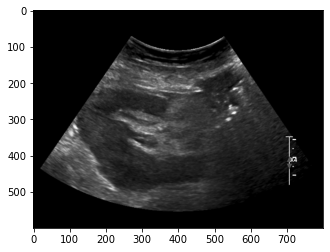

In [1]:
import cv2
import os
from matplotlib import pyplot as plt
import numpy as np
import skimage.transform
from scipy.ndimage import map_coordinates
import scipy
import scipy.ndimage
from scipy.stats import nakagami
from skimage.measure import label, regionprops
from skimage.morphology import convex_hull_image
from skimage.draw import polygon

img = cv2.imread("14_IM-0001-0181_frame0_anon.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap='gray')

In [30]:
def maybe_convert_gray(img):
    """
    Convert to grayscale image if not already

    :param img: image to convert
    :return: grayscale image
    """
    if (len(img.shape)==3):
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        return img

In [2]:
def find_mask(img, threshold=1/800, index=-2):
    """
    Create mask of outerboundaries of ultrasound image. Originally taken from echotools
    repository

    :param img: ultrasound image
    :param threshold: threshold used to determine boundaries
    :param index: index of connected component to use
    :return: mask of ROI
    """
    v = img
    diff_mean = (np.clip(v, 0, 1))
    # find connected components after threshold
    cc = label(diff_mean > threshold)
    v, c = np.unique(cc, return_counts=True)
    # find second largest connect component (largest is the background)
    second_largest_component = v[c.tolist().index(sorted(c)[index])]

    # take convex hull to remove small gaps
    # noinspection PyTypeChecker
    return convex_hull_image(np.where(cc == second_largest_component, 1, 0))

In [32]:
def get_scanlines(img):
    """
    Find outer scanlines of ultrasound image. This function 
    will likely require background except for ROI to be masked out. 
    Can be adapted if needed for other datasets. 

    :param img: ultrasound image
    :return: parameters defining scanlines to use to generate mask
    """
    left_line = []
    right_line = []

    start_row = 0
    h, w = img.shape
    min_col = w
    
    # Trace scanlines
    for i in range(h):
        row = img[i, :]
        if(np.count_nonzero(row)) > 1:
            nonzero = row.nonzero()
            if start_row==0:
                start_row = i
            if nonzero[0][0] < min_col:
                min_col = nonzero[0][0]
            if nonzero[0][0] > min_col + 5:
                break
            left_line.append(nonzero[0][0])
            right_line.append(nonzero[0][-1])
            
    # Find lines of best fit to scanlines
    y = np.arange(start_row, start_row+len(left_line))
    left = np.polyfit(np.array(left_line),y,1)
    right = np.polyfit(np.array(right_line),y,1)
    xi = (left[1]-right[1])/(right[0]-left[0])
    yi = left[0] * xi + left[1]
    slopes = (left, right)
    if yi > 0:
        yi = 0

    radius = img.shape[0] - yi
    center = left_line[0] + (right_line[0] - left_line[0])/2

    return center, radius, -yi, slopes

In [33]:
def get_triangle_mask(img_shape, center, radius, buffer, slopes, width=(0.05, 0.3)):
    """
    Generate triangle mask for shadow within boundaries of ROI.

    :param img_shape: ultrasound image shape
    :param center: location of intercept of lines
    :param radius: radius of polar image
    :param buffer: buffer added to top of image to fit full triangle mask
    :param slopes: slopes of scanlines
    :param width: range of widths for shadow
    :return: triangle mask
    """
    h, w = img_shape
    
    m1 = slopes[0][0]
    m2 = slopes[1][0]
    
    theta_low = min(np.arctan(1/m1), np.arctan(1/m2))
    theta_high = max(np.arctan(1/m1), np.arctan(1/m2))
    
    if width[1] > theta_high - theta_low:
        width[1] = theta_high - theta_low
    
    width = np.random.uniform(low=width[0], high=width[1], size=1)
    position = np.random.uniform(low=theta_low+width/2, high=theta_high-width/2, size=1)
    
    low_slope = 1/np.tan(position-width/2)
    high_slope = 1/np.tan(position+width/2)
    
    low_intercept = -buffer - low_slope * center
    high_intercept = -buffer - high_slope * center
    
    lines = [(low_slope[0], low_intercept[0]), (high_slope[0], high_intercept[0])]
    contours = []
    for (slope, intercept) in lines:
        bottom_intercept = (h-intercept) / slope
        if intercept >= 0 and intercept <= h:
            contours.append([0, intercept])
        elif(bottom_intercept >= 0 and bottom_intercept <= w):
            contours.append([bottom_intercept, h])
        else:
            contours.append([w, slope * w + intercept])
    contours.append([-lines[1][1] / lines[1][0], 0])
    contours.append([-lines[0][1] / lines[0][0], 0])
    mask = np.zeros((h, w))
    cv2.fillPoly(mask, pts = [np.array(contours, dtype=np.int32)], color=(1))
    return mask

In [34]:
def get_bounded_nakagami(length, shape, scale, min_val=0, max_val=255):
    """
    Pull Nakagami values from specified distribution within given range until
    mask is filled.

    :param length: number of values to generate
    :param shape: Nakagami shape parameter
    :param scale: Nakagami scale parameter
    :param min_val: minimum value allowed
    :param max_val: maximum value allowed
    :return: array of the specified number of values
    """
    vals = np.zeros(length)
    for i in range(length):
        val = -1
        while val < min_val or val > max_val:
            val = nakagami.rvs(shape, scale=scale, size=1)
        vals[i] = val
    return vals

In [35]:
def shadow_augmentation(img, shape=0.0372, scale=116, width=(0.05, 0.3)):
    """
    Pull Nakagami values from specified distribution within given range until
    mask is filled.

    :param img: image to add mask to
    :param shape: Nakagami shape parameter
    :param scale: Nakagami scale parameter
    :param width: range of widths for shadows
    :return: array of the specified number of values
    """
    gray_img = maybe_convert_gray(img)
    center, radius, buffer, slopes = get_scanlines(gray_img)
    top = (img[:, int(center)]!=0).argmax() + int(buffer)
    mask = get_triangle_mask(img.shape, center, radius, int(buffer), slopes, width=width)
    num_pix = int(mask.sum())
    nak = get_bounded_nakagami(num_pix, shape, scale, min_val=0, max_val=255) / 255 * np.max(img)
    masked_image = img.copy()
    masked_image[np.where(mask != 0)] = nak
    outer_mask = find_mask(img, index=-2)
    masked_image = masked_image * outer_mask
    return masked_image

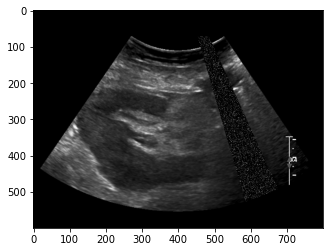

In [36]:
masked_image = shadow_augmentation(img)
plt.imshow(masked_image, cmap='gray')